In [1]:
import matplotlib.pyplot as plt
import torch

from src import read_dicom, Detector, Siddon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Read in the volume
volume, spacing = read_dicom("../data/cxr/")
volume[volume < 0] = 0.
isocenter = [0., 0., 0.]
siddon = Siddon(spacing, isocenter, volume, device)

# Send rays through the center of the volume
torch.tensor(volume.shape) * torch.tensor(spacing) / 2

tensor([180.0000, 180.0000, 166.2500], dtype=torch.float64)

In [3]:
# Make the detector plane
detector = Detector(
    sdr    =  300.,
    theta  =  torch.pi,
    phi    =  0,
    gamma  =  torch.pi / 2,
    bx     =  180.,
    by     =  180.,
    bz     =  166.25,
    device =  device,
)

angles = detector.angles
source, rays = detector.make_xrays(200, 200, 1.4e-2, 1.4e-2)

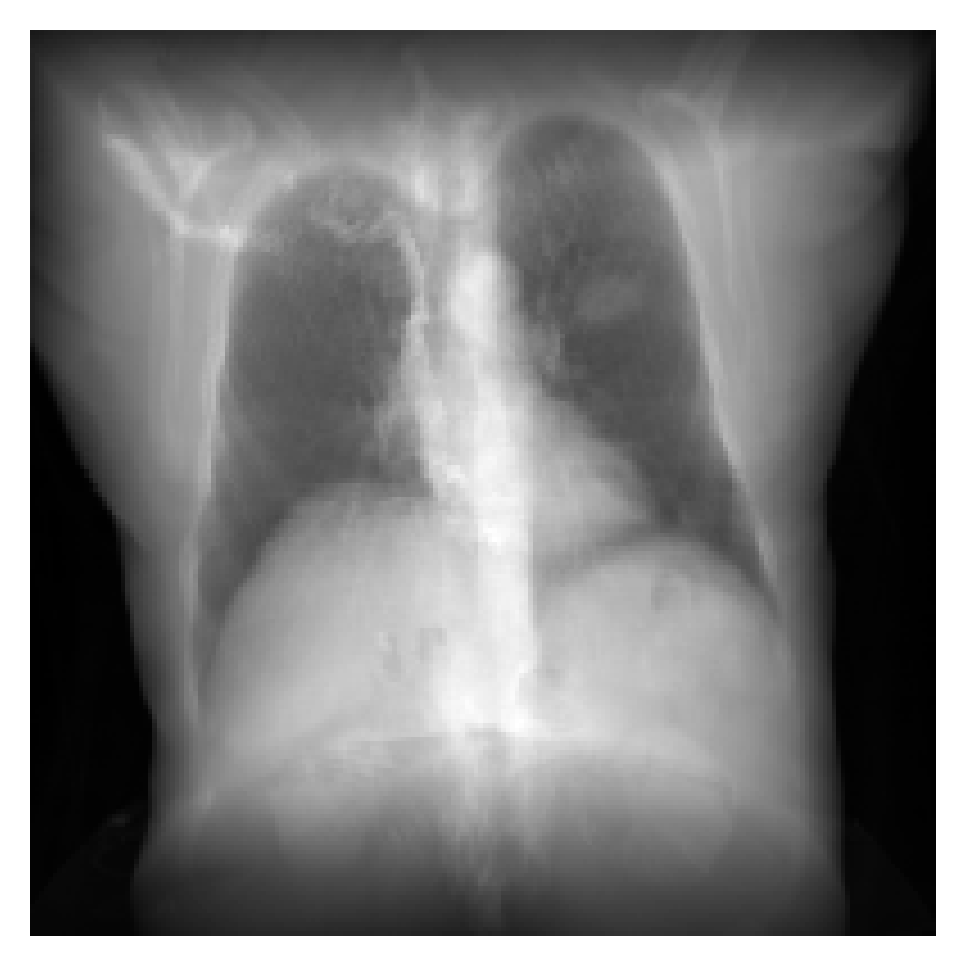

In [4]:
# Make the DRR
drr = siddon.raytrace(source, rays)

fig, ax = plt.subplots(dpi=300)
ax.imshow(drr.detach().cpu(), cmap="gray")
ax.axis("off")
plt.savefig("../figures/example_DRR.pdf", bbox_inches="tight")
plt.show()

In [5]:
%timeit siddon.raytrace(source, rays)

50.8 ms ± 99.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Test the gradients

In [6]:
drr.sum().backward()
detector.translation.grad, detector.angles.grad

(tensor([ 3.2582e+07,  9.0471e+03, -1.7463e+06], device='cuda:0'),
 tensor([ 2.4920e+08, -4.0063e+06,  3.2275e+08], device='cuda:0'))